In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jax import random
plt.rcParams["figure.figsize"] = (10,8)

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from src.rt_from_frequency_dynamics import *

In [3]:
raw_cases = pd.read_csv("../../rt-from-frequency-dynamics/data/location-case-counts.tsv", sep="\t")
raw_seq = pd.read_csv("../../rt-from-frequency-dynamics/data/location-variant-sequence-counts.tsv", sep="\t")

# Load US States (SVI)

In [4]:
import numpyro
from numpyro.infer import Predictive
from numpyro.infer.autoguide import AutoMultivariateNormal

In [5]:
# Load states
def load_SVI(LD, LM, optimizer, num_samples=1000, name="test", path="."):       
    X = make_breakpoint_splines(LD.cases, 20)
    data = LD.make_numpyro_input(X)

    # Load SVI
    SVIH = SVIHandler(optimizer=optimizer)
    guide = AutoMultivariateNormal(LM.model)
    SVIH.load_state(f"{path}/models/{name}_svi.p")
    
    # Get samples
    samples = SVIH.predict(LM.model, guide, data, num_samples=num_samples)
    return to_arviz(samples)

In [6]:
class LoadedSamples():
    def __init__(self, name, LD, dataset):
        self.name = name
        self.LD = LD
        self.dataset = dataset

In [7]:
def get_state_LD(rc, rs, loc):
    rc_l = rc[rc.location == loc].copy()
    rs_l = rs[rs.location==loc].copy()
    return LineageData(rc_l, rs_l)

def load_locations(rc, rs, locations, model_class, optimizer, **kwargs):
    n_locations = len(locations)
    loaded = dict()
    
    # Generation Time and Delays
    g, delays = get_standard_delays()
    LM = model_class(g, delays, 7, 0)
    
    for i, loc in enumerate(locations):
        LD = get_state_LD(raw_cases, raw_seq, loc)
        model_name = loc.replace(" ", "_")
        dataset = load_SVI(LD, LM, optimizer, name=model_name, **kwargs)
        loaded[loc] = LoadedSamples(model_name, LD, dataset)
        print(f'Location {loc} loaded ({i+1}/{n_locations}).')
    return loaded

In [10]:
locations = pd.unique(raw_seq.location)
locations = ["Washington", "California", "New York", "Michigan", "Florida"]
optimizer = numpyro.optim.Adam(step_size=1e-2)
num_samples = 3000

In [11]:
path_fixed = "../sims/all-states-preprint-fixed"
loaded_fixed = load_locations(raw_cases, raw_seq, locations, FixedGrowthModel, optimizer, 
              num_samples=num_samples, path=path_fixed)


Location Washington loaded (1/5).
Location California loaded (2/5).
Location New York loaded (3/5).
Location Michigan loaded (4/5).
Location Florida loaded (5/5).


In [12]:
path_free = "../sims/all-states-preprint-free"
loaded_free = load_locations(raw_cases, raw_seq, locations, FreeGrowthModel, optimizer, 
              num_samples=num_samples, path=path_free)

Location Washington loaded (1/5).
Location California loaded (2/5).
Location New York loaded (3/5).
Location Michigan loaded (4/5).
Location Florida loaded (5/5).


In [13]:
ps = DefaultAes.ps
alphas = DefaultAes.alphas
lineage_colors =["#2e5eaa", "#5adbff",  "#56e39f","#b4c5e4", "#f03a47",  "#f5bb00", "#9e4244", "#808080"] 

In [14]:
import matplotlib
font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 18}

matplotlib.rc('font', **font)

In [15]:
def plot_total_by_obs_frequency(ax, dataset, LD, total, colors):
    T, D = LD.seq_counts.shape
    t = jnp.arange(0, T, 1)
    obs_freq = jnp.divide(LD.seq_counts, LD.seq_counts.sum(axis=1)[:, None])
    
    # Make figure
    ax.axhline(y=1.0, color='k', linestyle='--')
    bottom = jnp.zeros(t.shape)
    for lineage in range(D):
        ax.bar(t, obs_freq[:, lineage] * total, bottom = bottom,
                color=colors[lineage])
        bottom = obs_freq[:, lineage] * total + bottom
        
def plot_total_by_median_frequency(ax, dataset, LD, total, colors):
    T, D = LD.seq_counts.shape
    t = jnp.arange(0, T, 1)
    med_freq = get_median(dataset, "freq")
    
    # Make figure
    ax.axhline(y=1.0, color='k', linestyle='--')
    bottom = jnp.zeros(t.shape)
    for lineage in range(D):
        ax.bar(t, med_freq[:, lineage] * total, bottom = bottom,
                color=colors[lineage])
        bottom = med_freq[:, lineage] * total + bottom
    

In [16]:
# Figure 1:
import matplotlib.transforms as mtransforms

def figure_1(dataset, LD, ps, alphas, colors):
    fig = plt.figure(figsize=(30, 24))

    # Top left
    ax1 = fig.add_subplot(3,2,1)
    plot_cases(ax1, LD)
    plot_posterior_smooth_EC(ax1, dataset, ps, alphas, colors[0])
    ax1.set_ylabel("Posterior smoothed cases") 
    
    # Top right
    ax2 = fig.add_subplot(3, 2, 2, sharey=ax1)
    plot_cases(ax2, LD)
    plot_posterior_I(ax2, dataset, ps, alphas, colors)
    plt.setp(ax2.get_yticklabels(), visible=False)

    # middle left
    ax3 = fig.add_subplot(6, 2, 5, sharex=ax1)
    plot_posterior_average_R(ax3, dataset, ps, alphas, colors[0])
    add_dates(ax3, LD.dates)
    ax3.set_ylabel(r"$R_{t}$") 

    
    # middle right
    ax4 = fig.add_subplot(6, 2, 6, sharex=ax2, sharey=ax3)
    plot_R_censored(ax4, dataset, ps, alphas, colors, thres=0.001)
    add_dates(ax4, LD.dates)
    plt.setp(ax4.get_yticklabels(), visible=False)

    #  Bottom left
    ax5a = fig.add_subplot(8, 3, 13)
    plot_total_by_obs_frequency(ax5a, dataset, LD, LD.seq_counts.sum(axis=1), colors)

    ax5b = fig.add_subplot(8, 3, 16, sharex=ax5a)
    plot_total_by_obs_frequency(ax5b, dataset, LD, jnp.full(LD.cases.shape[-1], fill_value=1), colors)
    add_dates(ax5b, LD.dates, sep=2)

    # Bottom middle
    ax6 = fig.add_subplot(4, 3, 8, sharey=ax1)
    plot_cases(ax6, LD)
    add_dates(ax6, LD.dates, sep=2)

    # Bottom right
    ax7 = fig.add_subplot(4, 3, 9, sharey=ax6)
    plot_total_by_median_frequency(ax7, dataset, LD, LD.cases, colors)
    add_dates(ax7, LD.dates, sep=2)
    plt.setp(ax7.get_yticklabels(), visible=False)
    
    
    # Add labels
    
    axs = [ax1, ax2, ax5a]
    labels = ["(a)", "(b)", "(c)"]
    
    for label, ax in zip(labels, axs):
        trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')
        
    fig.subplots_adjust(wspace=0.15, hspace=0.25)

In [17]:
# Figure 1:
import matplotlib.transforms as mtransforms

def figure_1(dataset, LD, ps, alphas, colors):
    fig = plt.figure(figsize=(30, 24))

    # Top left
    ax1 = fig.add_subplot(3,2,1)
    plot_cases(ax1, LD)
    plot_posterior_smooth_EC(ax1, dataset, ps, alphas, colors[0])
    ax1.set_ylabel("Posterior smoothed cases") 
    
    # Top right
    ax2 = fig.add_subplot(3, 2, 2, sharey=ax1)
    plot_cases(ax2, LD)
    plot_posterior_I(ax2, dataset, ps, alphas, colors)
    plt.setp(ax2.get_yticklabels(), visible=False)

    # middle left
    ax3 = fig.add_subplot(6, 2, 5, sharex=ax1)
    plot_posterior_average_R(ax3, dataset, ps, alphas, colors[0])
    add_dates(ax3, LD.dates)
    ax3.set_ylabel(r"$R_{t}$") 

    
    # middle right
    ax4 = fig.add_subplot(6, 2, 6, sharex=ax2, sharey=ax3)
    plot_R_censored(ax4, dataset, ps, alphas, colors, thres=0.001)
    add_dates(ax4, LD.dates)
    plt.setp(ax4.get_yticklabels(), visible=False)

    #  Bottom left
    ax5a = fig.add_subplot(8, 3, 13)
    plot_total_by_obs_frequency(ax5a, dataset, LD, LD.seq_counts.sum(axis=1), colors)

    ax5b = fig.add_subplot(8, 3, 16, sharex=ax5a)
    plot_total_by_obs_frequency(ax5b, dataset, LD, jnp.full(LD.cases.shape[-1], fill_value=1), colors)
    add_dates(ax5b, LD.dates, sep=2)

    # Bottom middle
    ax6 = fig.add_subplot(4, 3, 8)
    plot_posterior_frequency(ax6, dataset, ps, alphas, colors)
    plot_observed_frequency_size(ax6, LD, colors, lambda n: 2.5*jnp.sqrt(n))
    add_dates(ax6, LD.dates, sep=2)
    ax6.set_ylabel("Posterior variant frequencies")
    
    # Bottom right
    #ax7a = fig.add_subplot(8, 3, 15, sharey=ax1)
    #plot_cases(ax7a, LD)
    #add_dates(ax7a, LD.dates, sep=2) 
    #ax7b.set_ylabel("Observed cases") 
   
    
    #ax7b = fig.add_subplot(8, 3, 18, sharey=ax1)
    ax7b = fig.add_subplot(4, 3, 9, sharey=ax1)
    plot_total_by_median_frequency(ax7b, dataset, LD, LD.cases, colors)
    add_dates(ax7b, LD.dates, sep=2)
    ax7b.set_ylabel("Median variant cases") 
 
    #fig.text(0.635, 6.5 / 16, 'Cases counts', va='center', rotation='vertical')

    # Add labels
    axs = [ax1, ax2, ax5a]
    labels = ["(a)", "(b)", "(c)"]
    
    for label, ax in zip(labels, axs):
        trans = mtransforms.ScaledTranslation(-42/72, 14/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')
        
    fig.subplots_adjust(wspace=0.15, hspace=0.25)
    return fig

In [18]:
def unpack_model(loaded, loc):
    return loaded[loc].dataset, loaded[loc].LD

In [19]:
dataset, LD = unpack_model(loaded_free, "Washington")

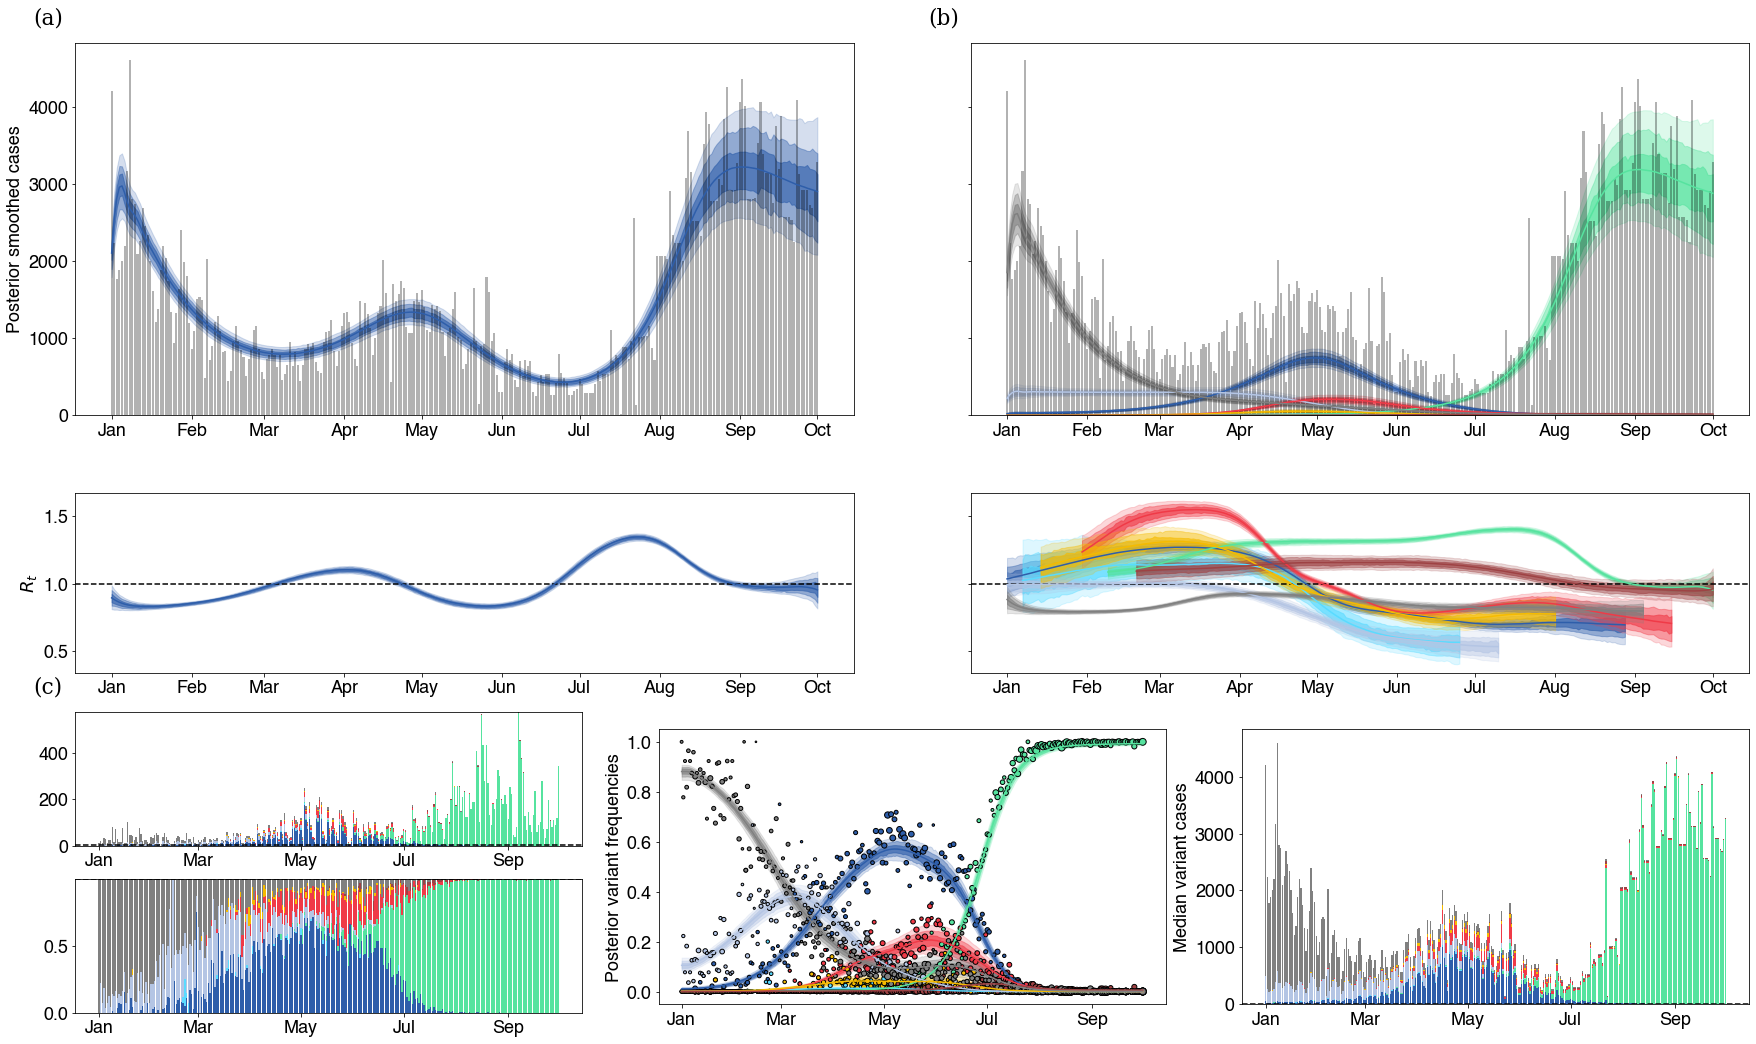

In [20]:
fig_1 = figure_1(dataset, LD, ps, alphas, lineage_colors)

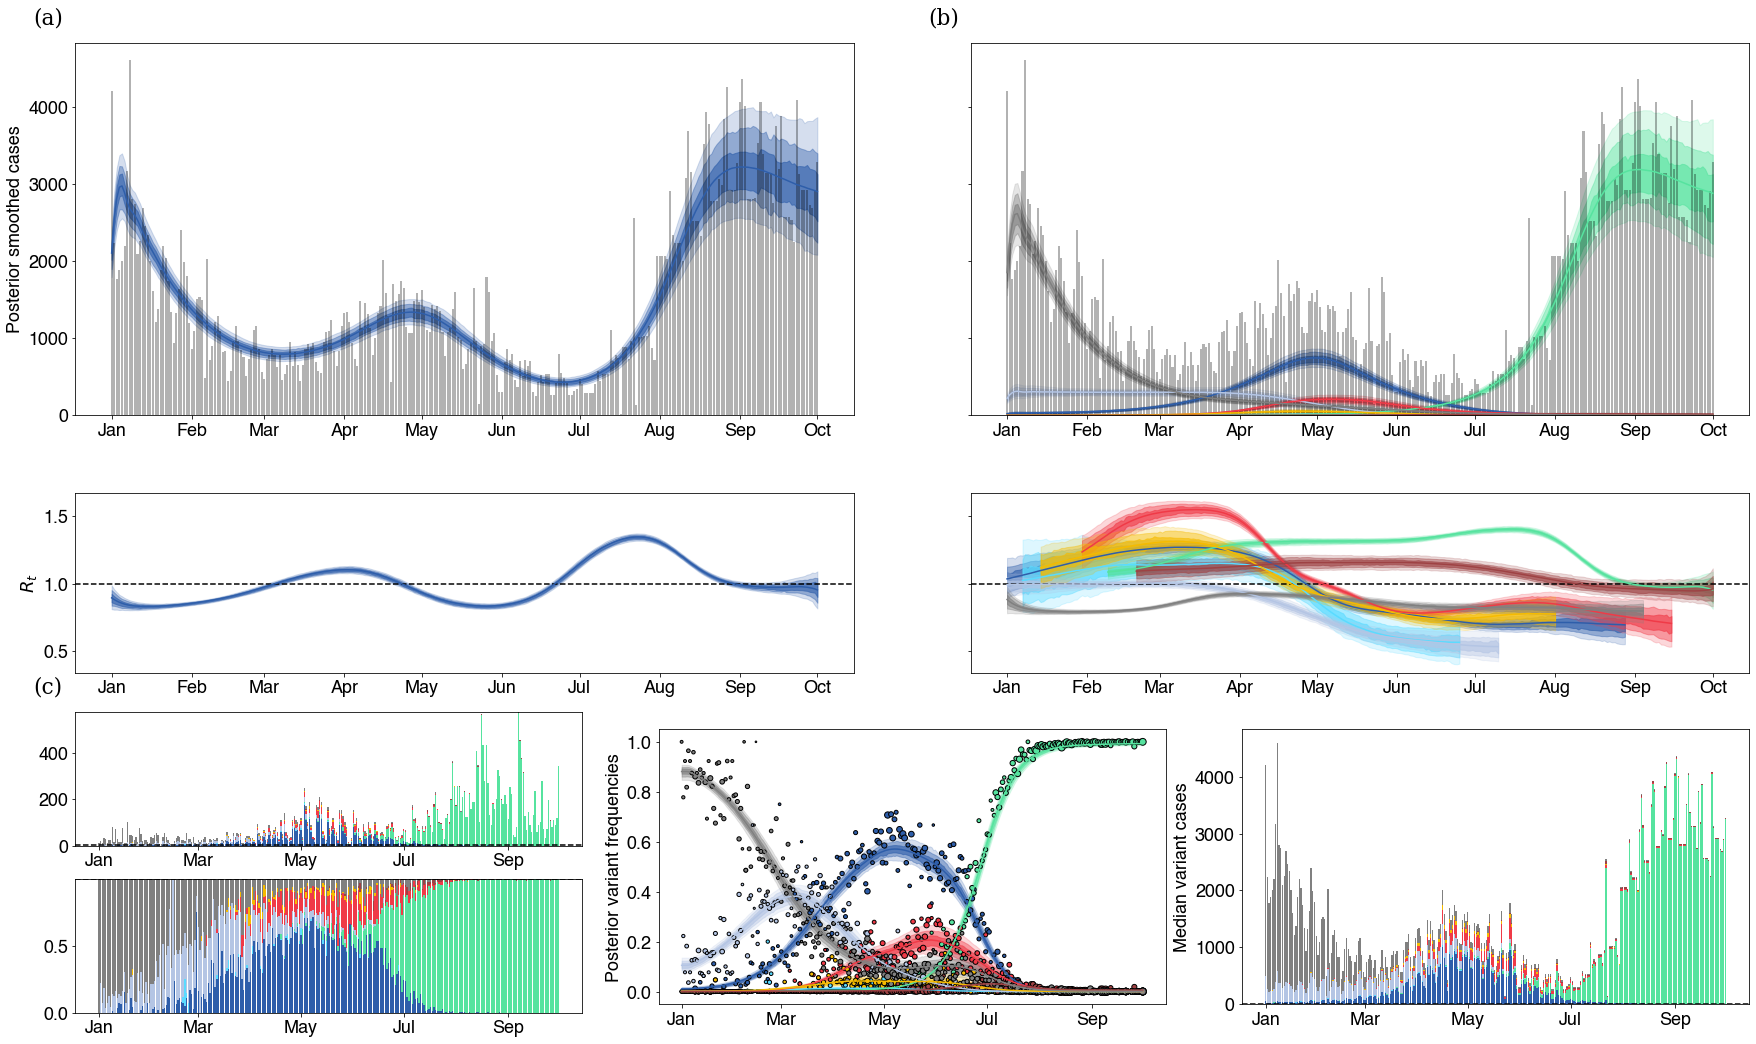

In [22]:
fig_1

In [33]:
fig_1.savefig("../manuscript/figs/fig_1.png", facecolor="w", bbox_inches='tight')

In [34]:
def figure_2(dataset, LD, ps, alphas, colors):
    # Figure 2
    fig = plt.figure(figsize=(24, 24))

    # Top left
    ax1 = fig.add_subplot(2,2,1)
    plot_cases(ax1, LD)
    plot_posterior_smooth_EC(ax1, dataset, ps, alphas, colors[0])
    ax1.set_ylabel("Posterior smoothed cases")
    
    # Top right
    ax2 = fig.add_subplot(2,2,2, sharey=ax1)
    plot_posterior_I(ax2, dataset, ps, alphas, colors)
    plt.setp(ax2.get_yticklabels(), visible=False)

    # Bottom left
    ax3 = fig.add_subplot(2,2,3, sharex=ax1)
    plot_posterior_frequency(ax3, dataset, ps, alphas, colors)
    plot_observed_frequency_size(ax3, LD, colors, lambda n: 2.5*jnp.sqrt(n))
    add_dates(ax3, LD.dates)
    ax3.set_ylabel("Posterior lineage frequencies")

    # Bottom right 1
    ax4 = fig.add_subplot(4,2,6, sharex=ax2)
    plot_R_censored(ax4, dataset, ps, alphas, colors, thres=0.005)
    add_dates(ax4, LD.dates)
    ax4.set_ylabel(r"$R_{t}$")

    # Bottom right 1
    ax5 = fig.add_subplot(4,2,8)
    plot_growth_advantage(ax5, dataset, LD, ps, alphas, colors)
    ax5.set_ylabel("Growth Advantage")

    
    axs = [ax1, ax2, ax3, ax4, ax5]
    labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]
    
    for label, ax in zip(labels, axs):
        trans = mtransforms.ScaledTranslation(-32/72, 8/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')
    plt.tight_layout()
    
    fig.subplots_adjust(wspace=0.15, hspace=0.1)
    return fig

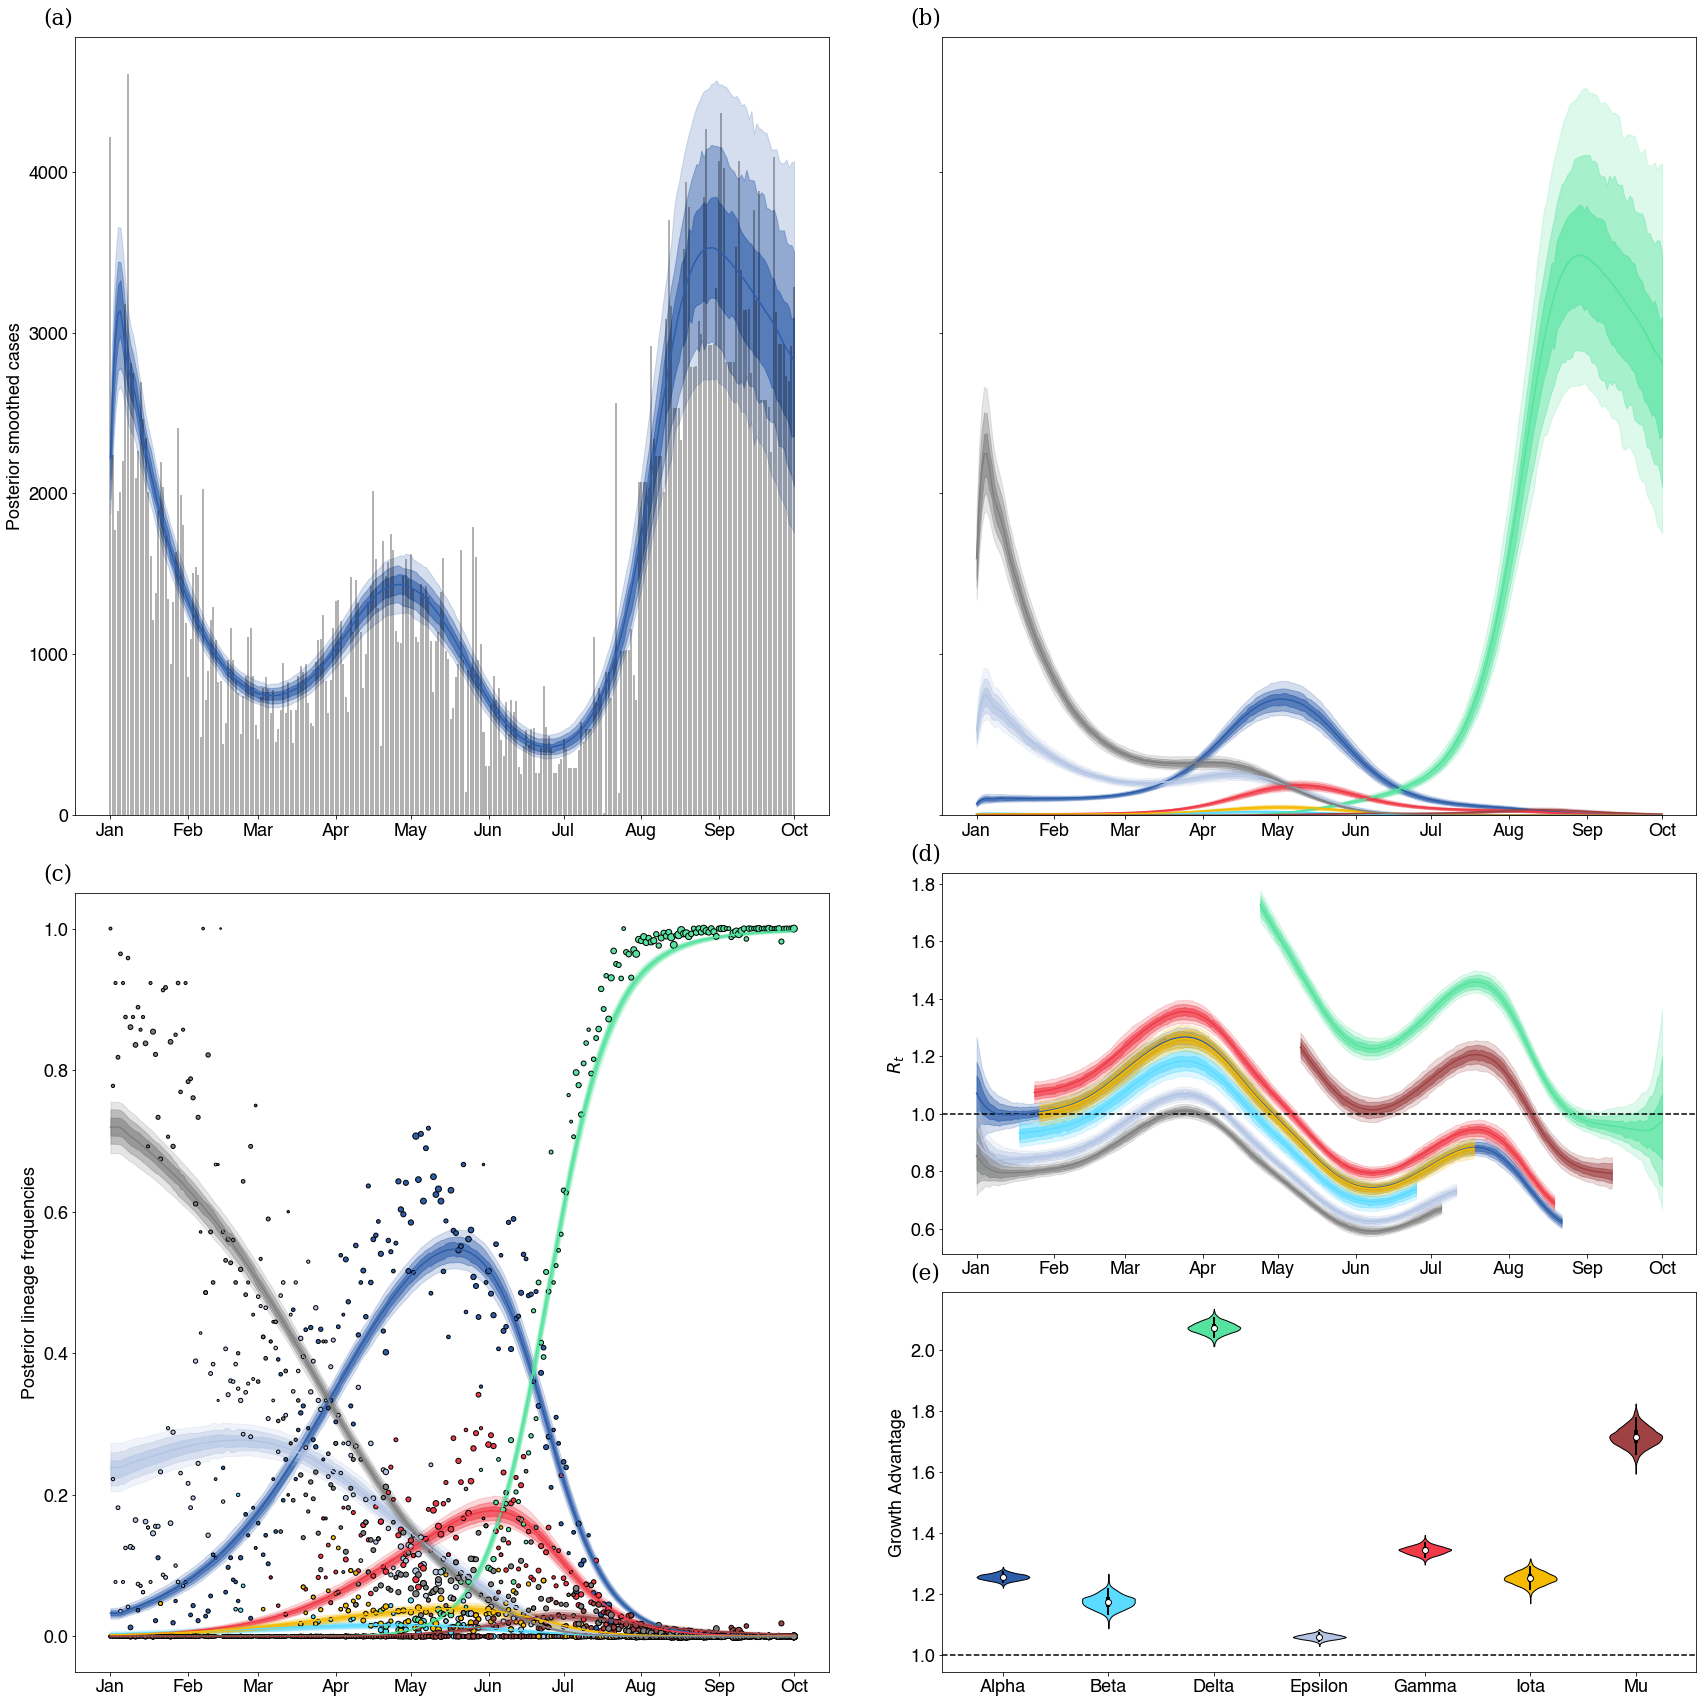

In [35]:
dataset, LD = unpack_model(loaded_fixed, "Washington")
fig_2 = figure_2(dataset, LD, ps, alphas, lineage_colors)

In [61]:
fig_2_locs = ["Washington", "California", "New York", "Michigan", "Florida"]

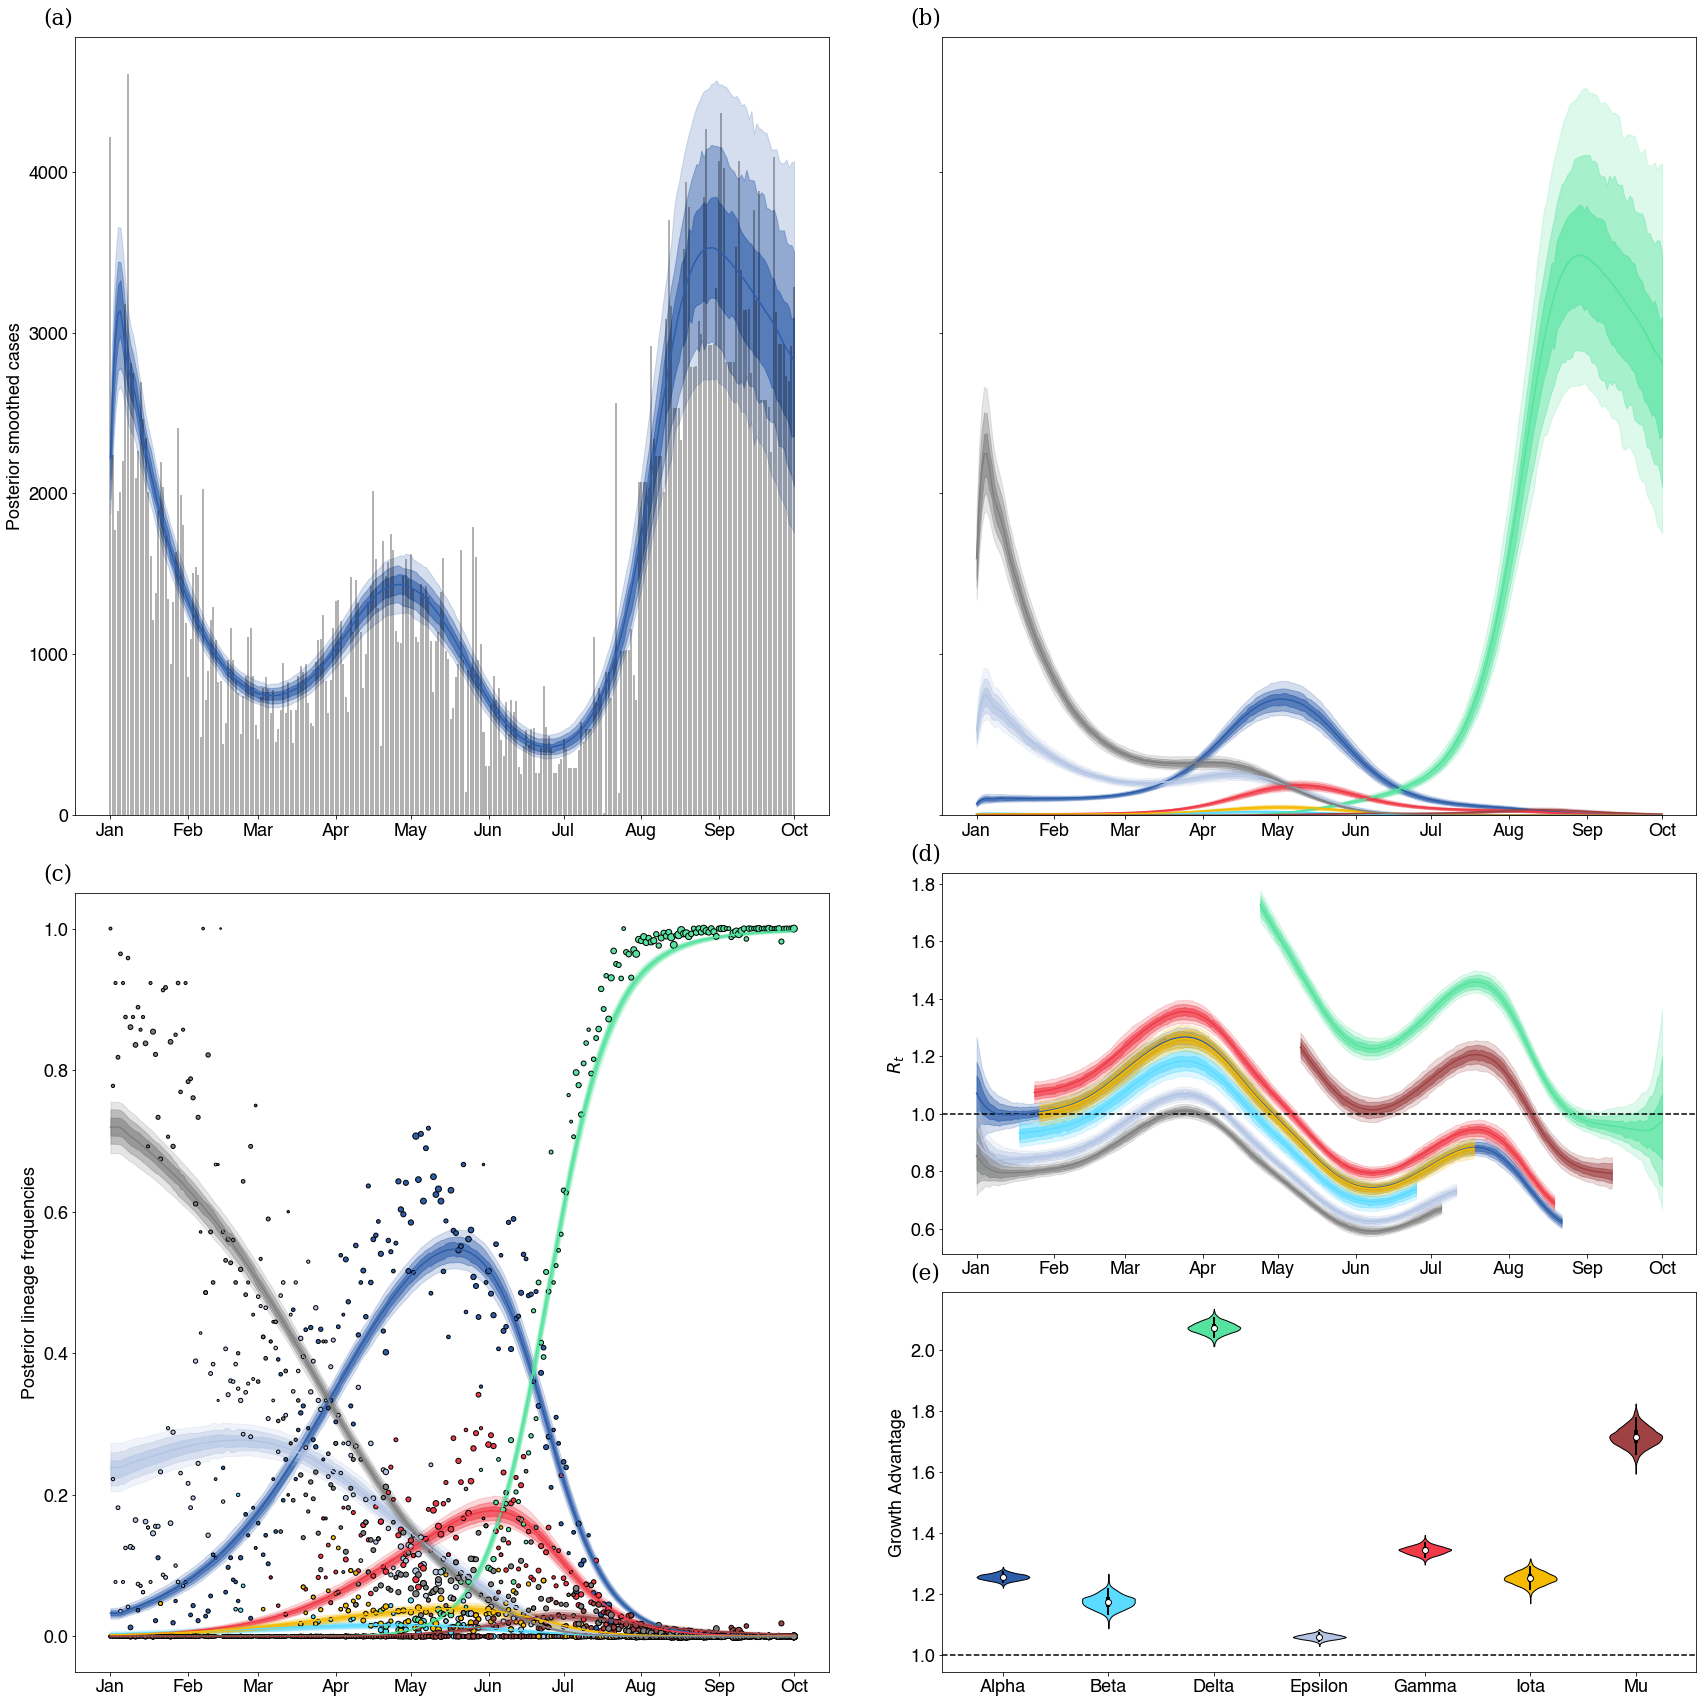

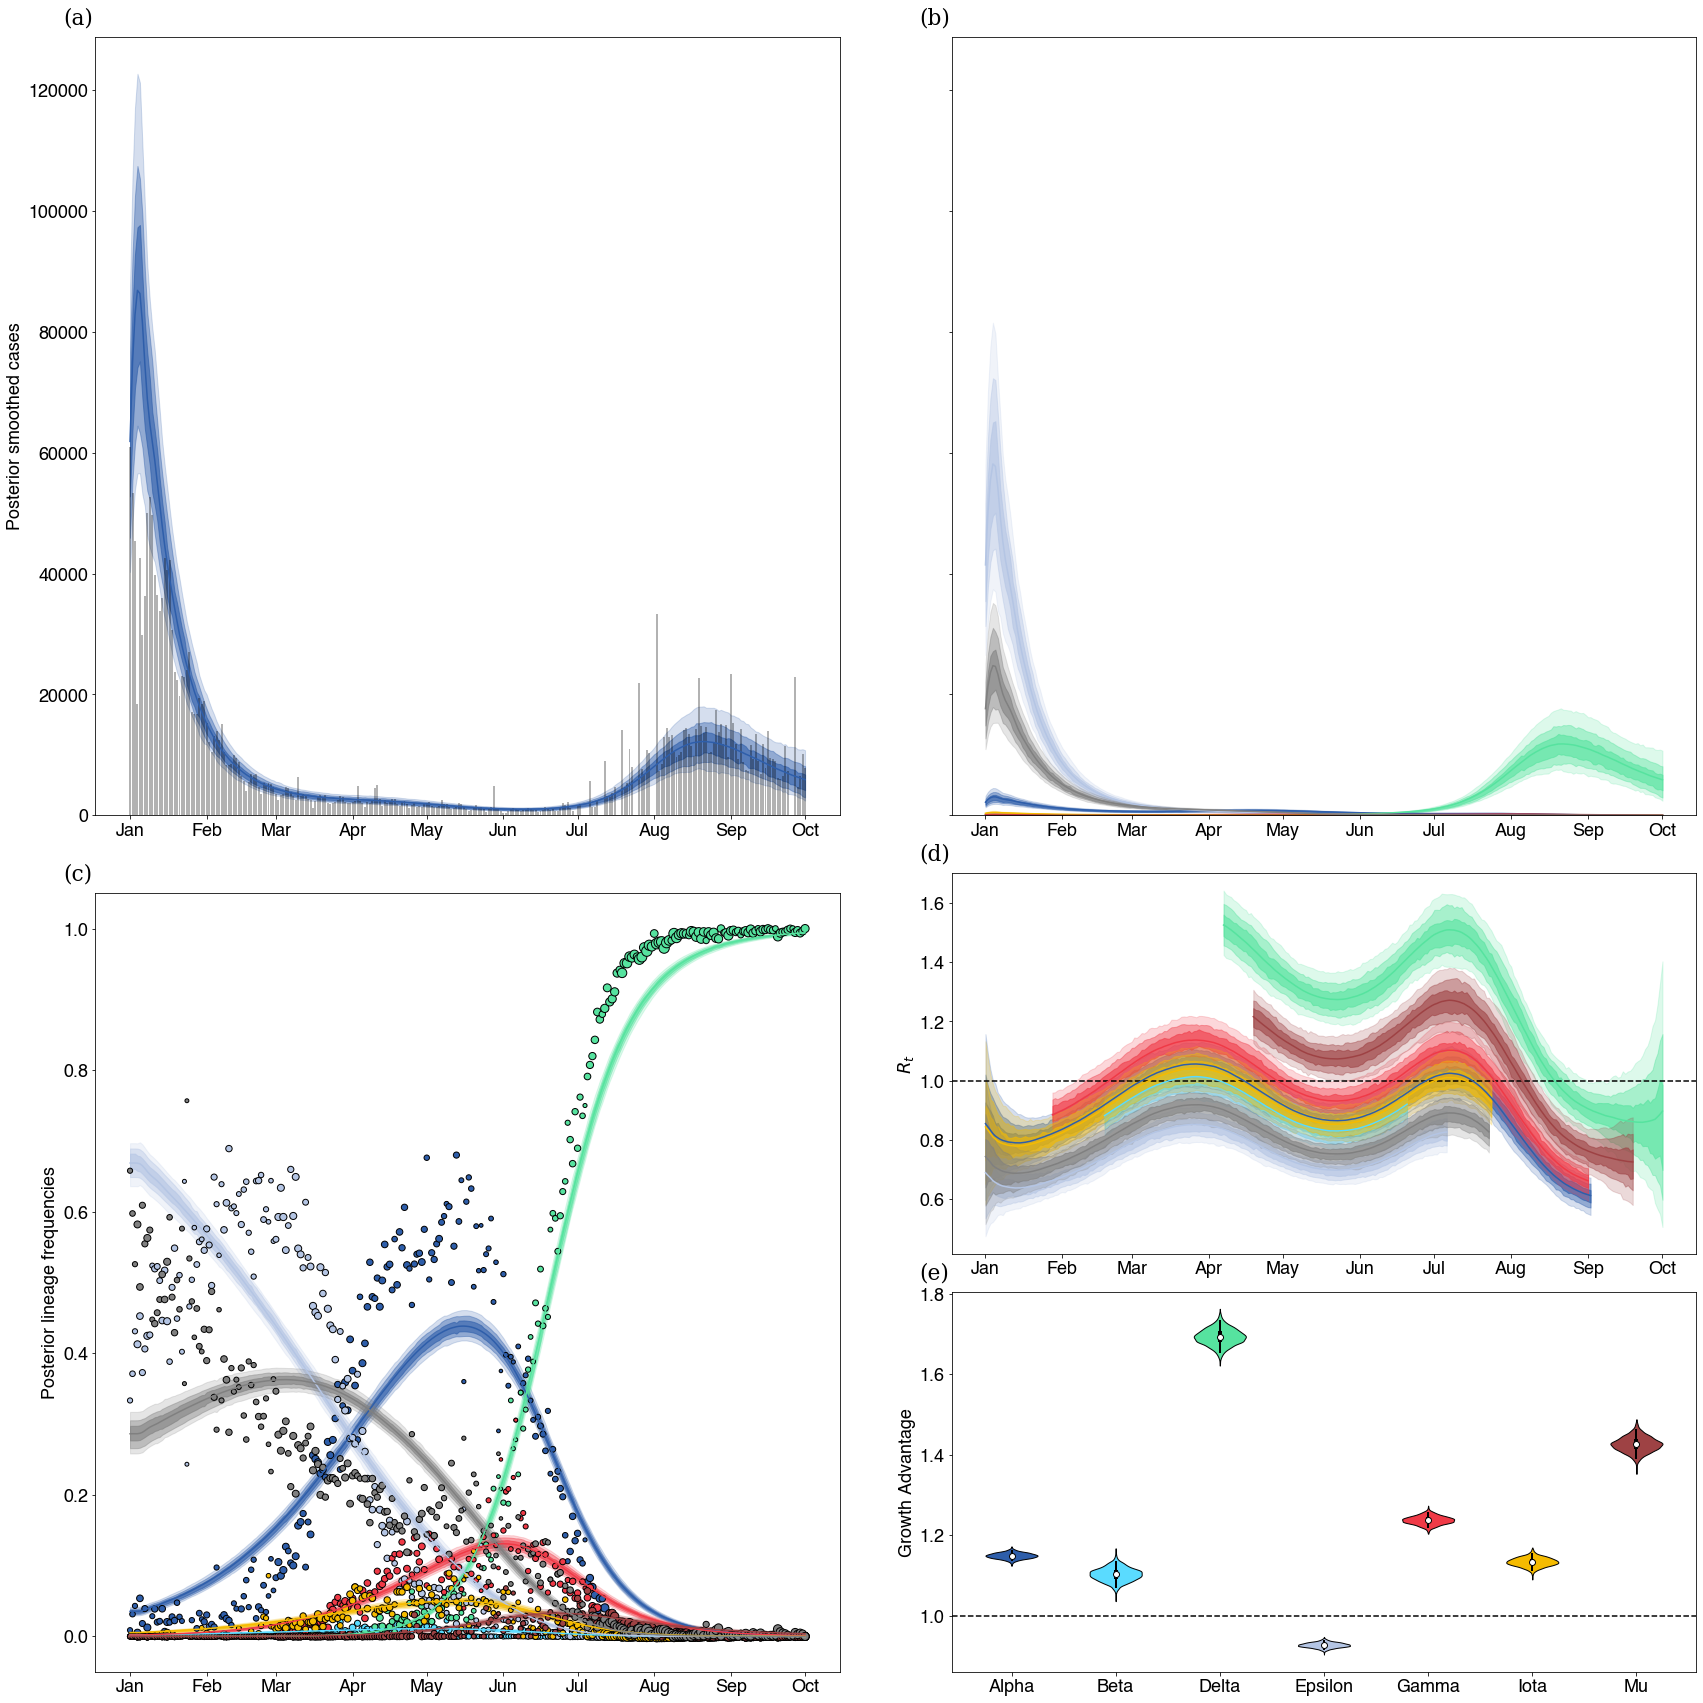

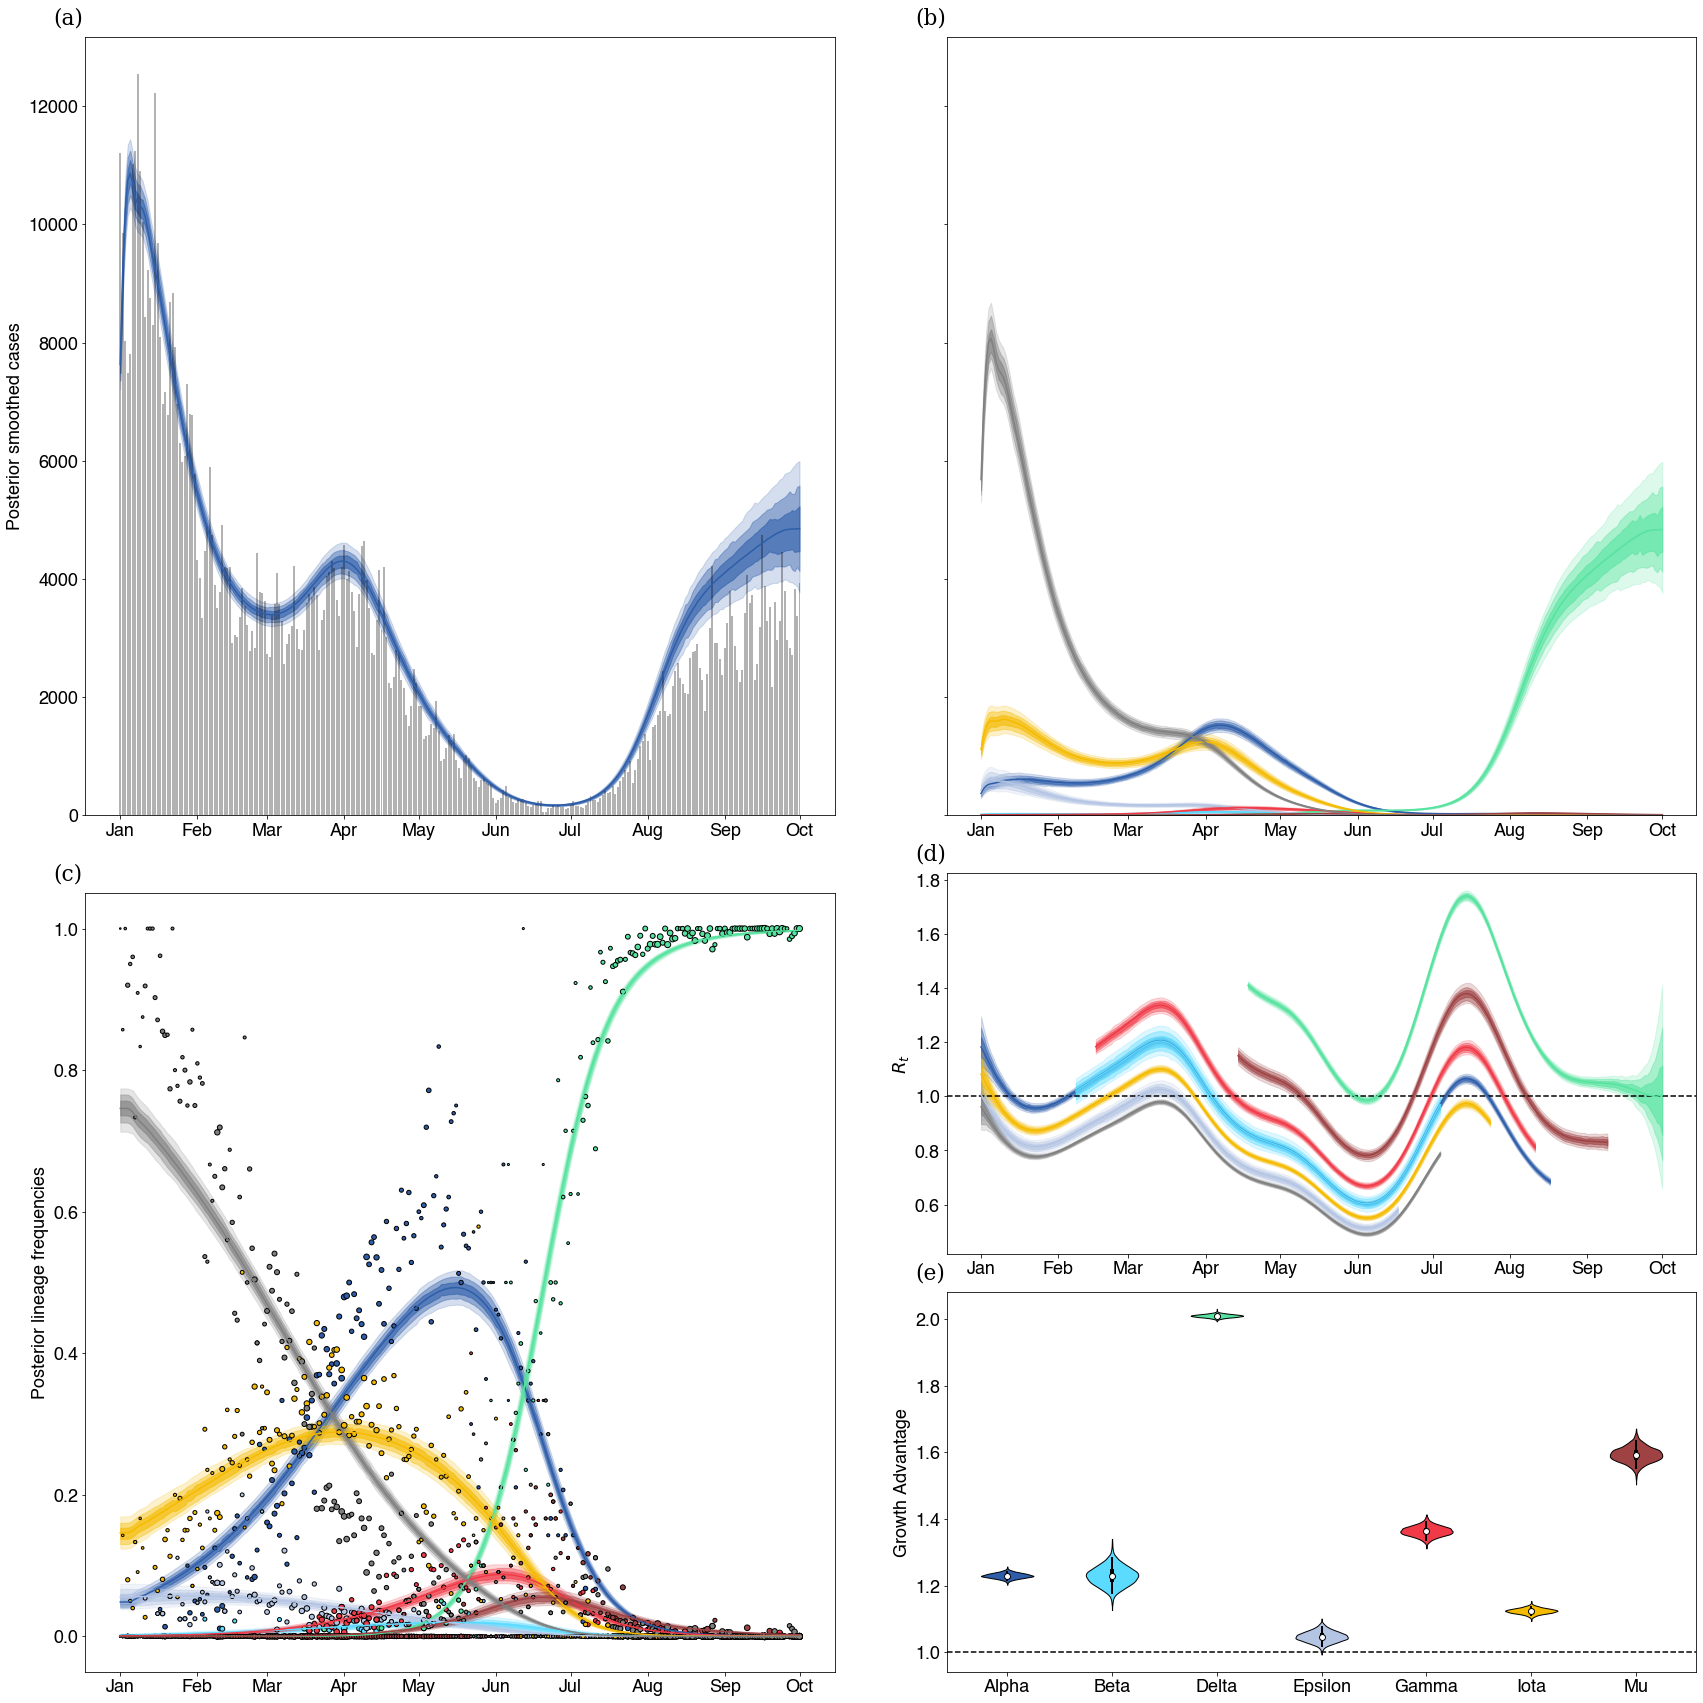

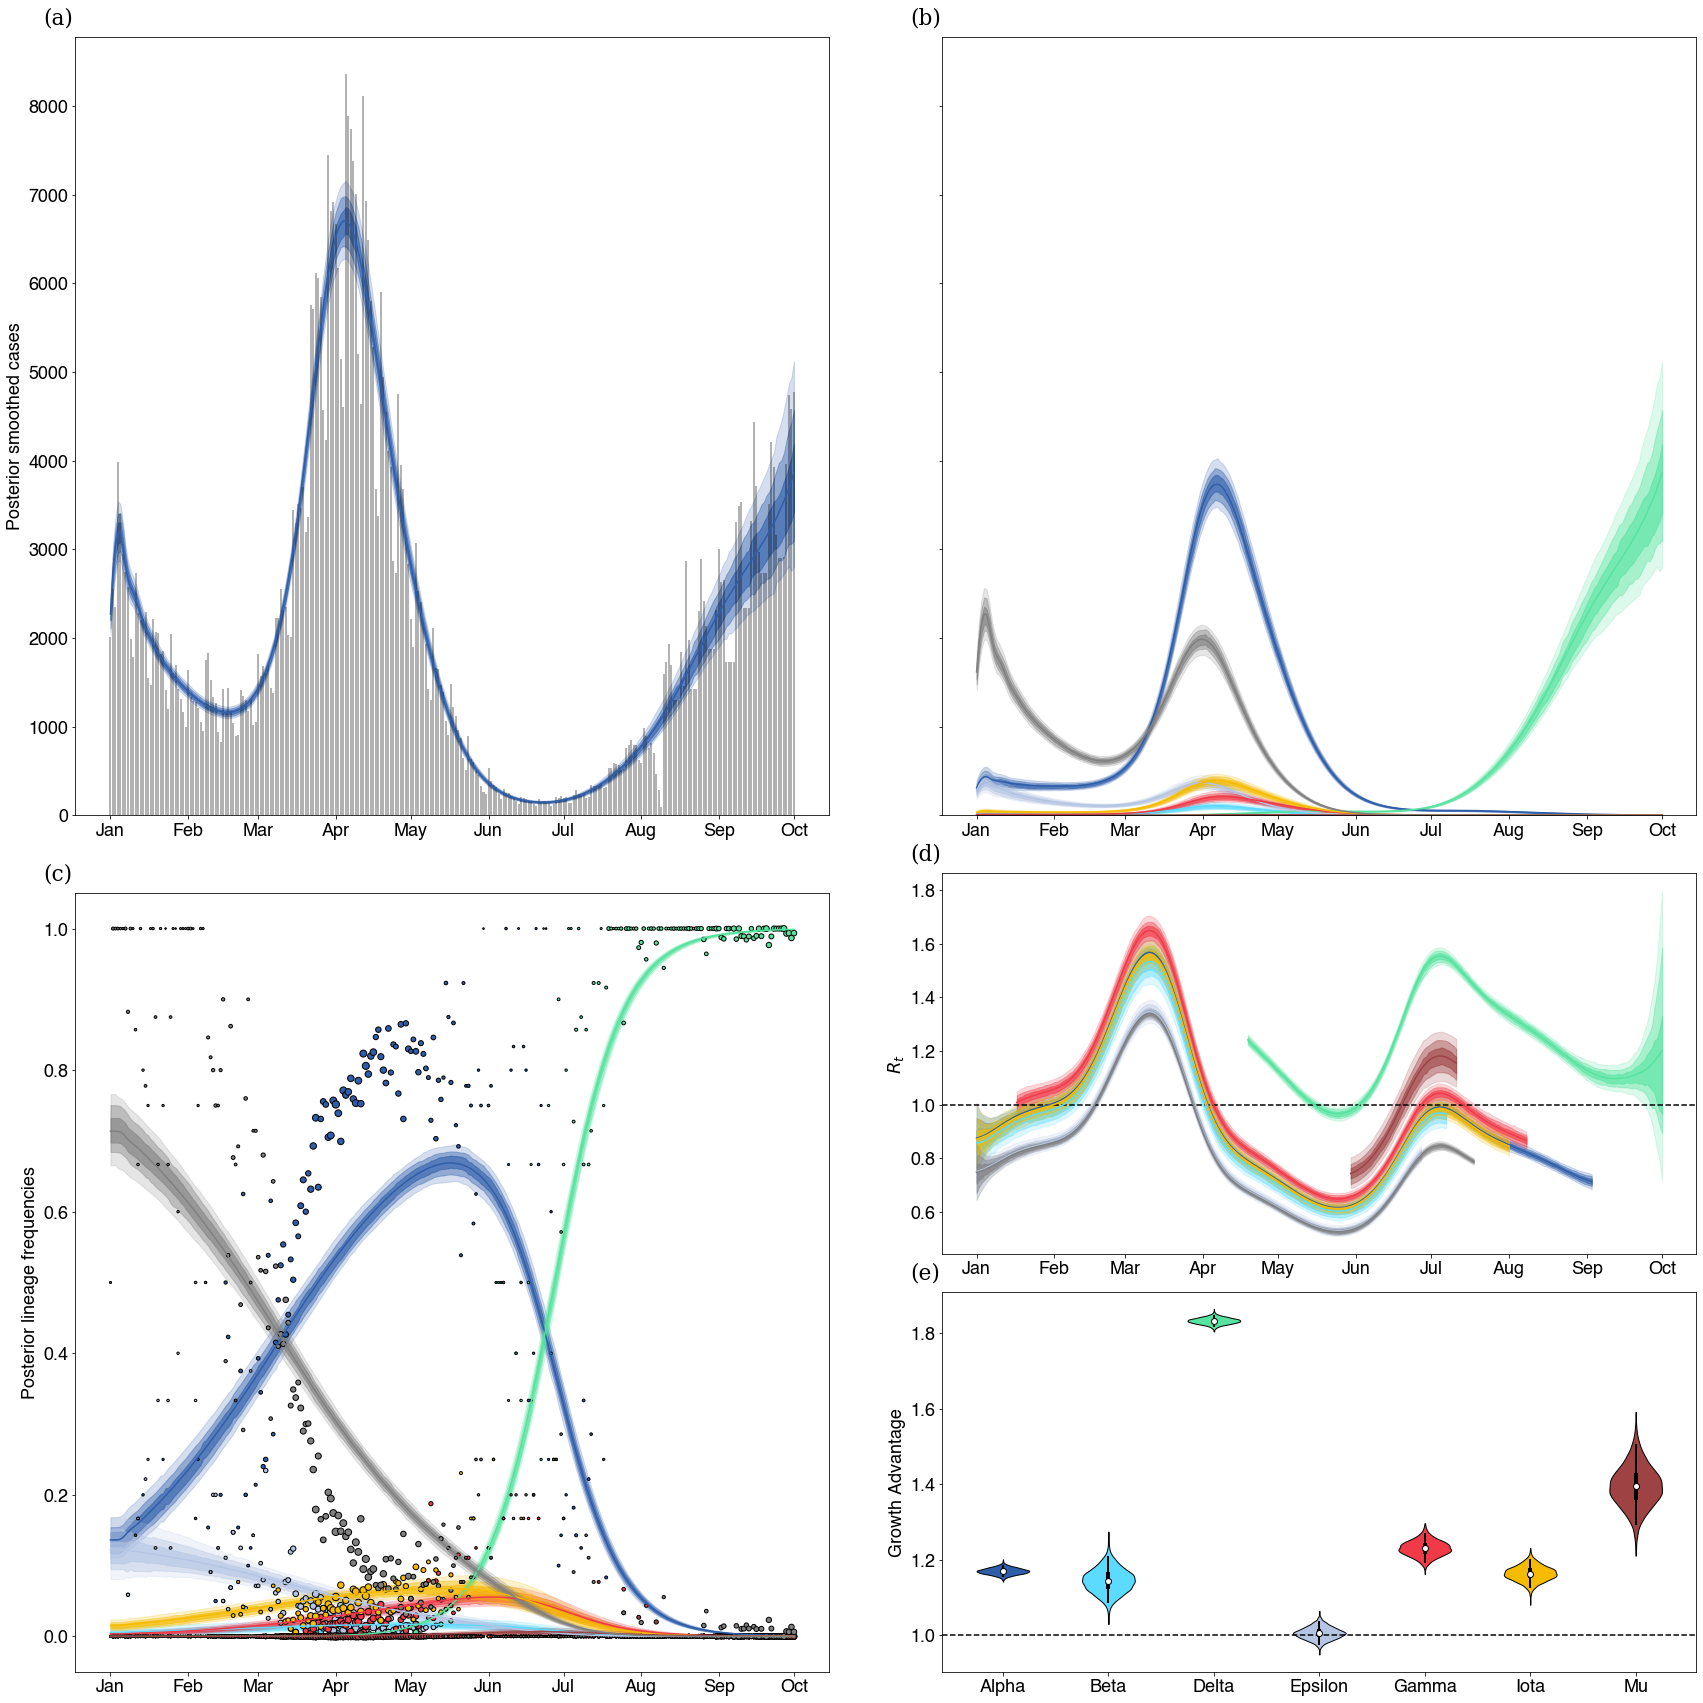

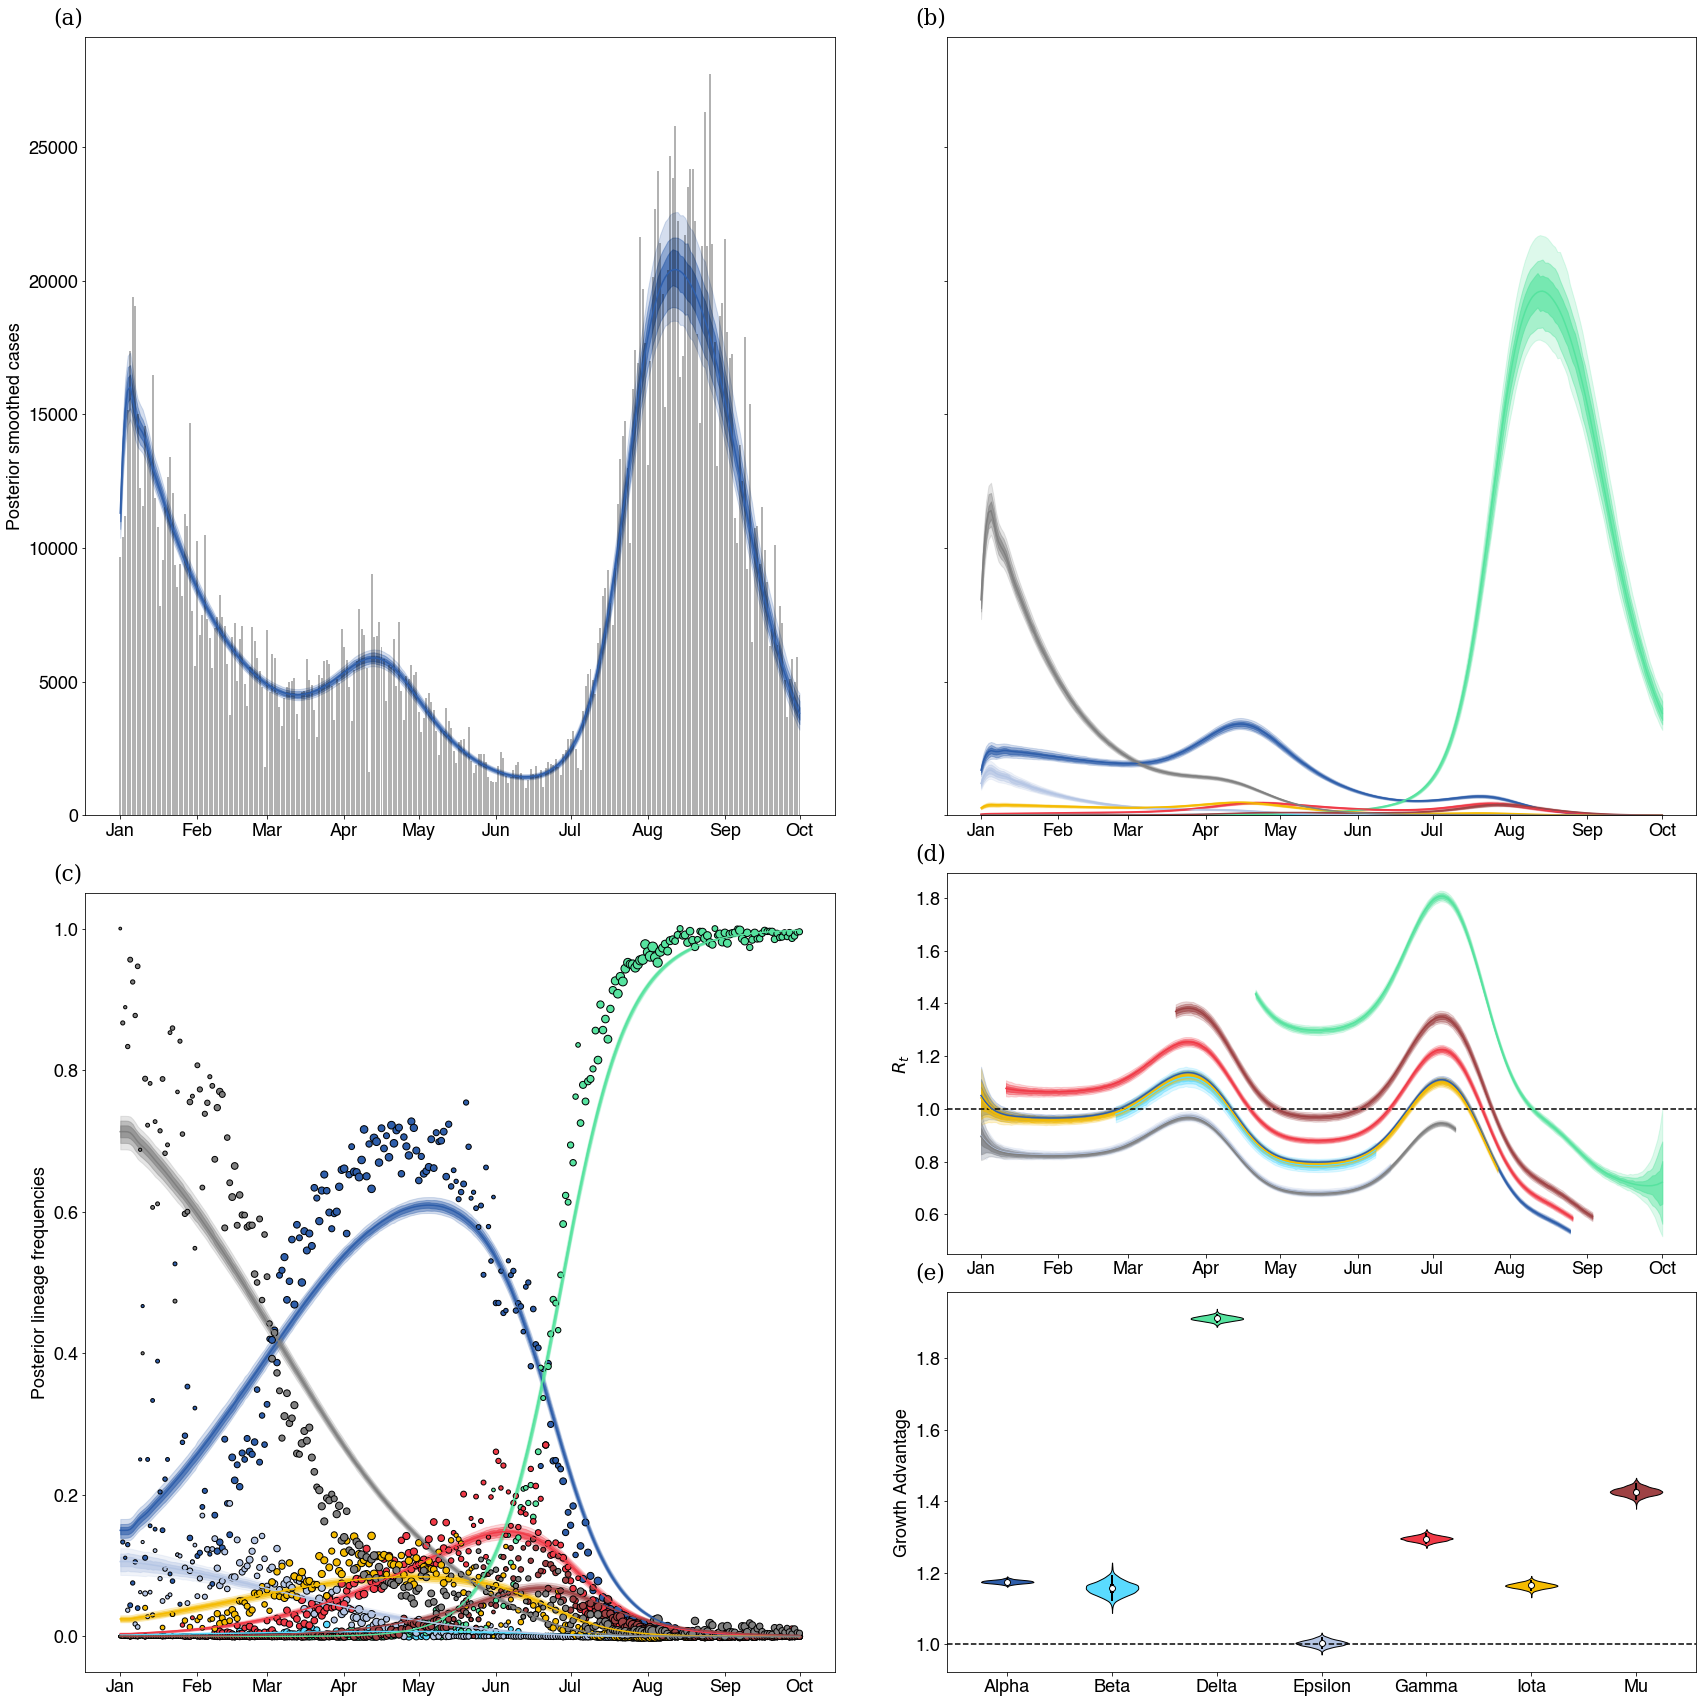

In [62]:
for loc in fig_2_locs:
    dataset, LD = unpack_model(loaded_fixed, loc)
    fig_2_loc = figure_2(dataset, LD, ps, alphas, lineage_colors)
    fig_2_loc.savefig(f"../manuscript/figs/fig_2_{loc}.png", facecolor="w", bbox_inches='tight')

## Figure 3

In [38]:
ga_df = pd.read_csv(f"{path_fixed}/ga/ga_combined.csv")

In [42]:
## Figure 3
def figure_3(ga_df, LD, ps, alphas, colors):
    fig = plt.figure(figsize=(20, 20))
  
    variants = pd.unique(ga_df.variant)
    locations = pd.unique(ga_df.location)
    location_map = {l: -i for i, l in enumerate(locations)}

    
    # Sort level of confidence  
    _lw = [1.5, 2.5, 3.5]
    
    # Left panel
    ax1 = fig.add_subplot(1,2,1)
    ax1.axvline(x=1, lw=2,linestyle='dashed', color="k")

    for v, var in enumerate(variants):
        this_lineage = ga_df[ga_df.variant == var]
        location_num = this_lineage["location"].map(location_map)
        ax1.scatter(this_lineage.median_ga.values, location_num, 
                    color=colors[v],
                    edgecolors="k",
                    s = 45,
                    zorder = 3)
        
        # Plot error bars for each level of credibility
        for i, p in enumerate(ps):
            _p = int(p * 100)
            l_err = this_lineage.median_ga.values - this_lineage[f"ga_lower_{_p}"].values
            r_err = this_lineage[f"ga_upper_{_p}"].values - this_lineage.median_ga.values 
            ax1.errorbar(this_lineage.median_ga.values, location_num,
                         xerr=[l_err, r_err], 
                          fmt = 'none',
                         color = colors[v], elinewidth = _lw[i])
        
    
    # Adding state labels
    ax1.set_yticks(np.arange(0, -len(locations), -1))
    ax1.set_yticklabels([l.replace("_", " ") for l in locations])
    
    # Adding axis label
    ax1.set_xlabel("Inferred Growth Advantage")
    
    # Right plot
    ax2 = fig.add_subplot(2,2,2)
    ax2.axhline(y=1, lw=2, linestyle='dashed', color="k")

    violin_data = [ga_df[ga_df.variant == v].median_ga.values for v in variants]
    parts = ax2.violinplot(violin_data, 
                           showmeans=False, 
                           showmedians=False, 
                           showextrema=False)
    
    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    for v, var in enumerate(variants):
        this_lineage = ga_df[ga_df.variant == var]
        ax2.scatter([v+1 for i in range(len(this_lineage))],
                    this_lineage.median_ga.values, 
                    color=colors[v],
                    edgecolors="k",
                    s = 45,
                    zorder = 3) 
    
    ax2.set_ylabel("Median Growth Advantage")
    ax2.set_xticks(np.arange(1, len(variants)+1, 1))
    ax2.set_xticklabels(variants)
    return fig

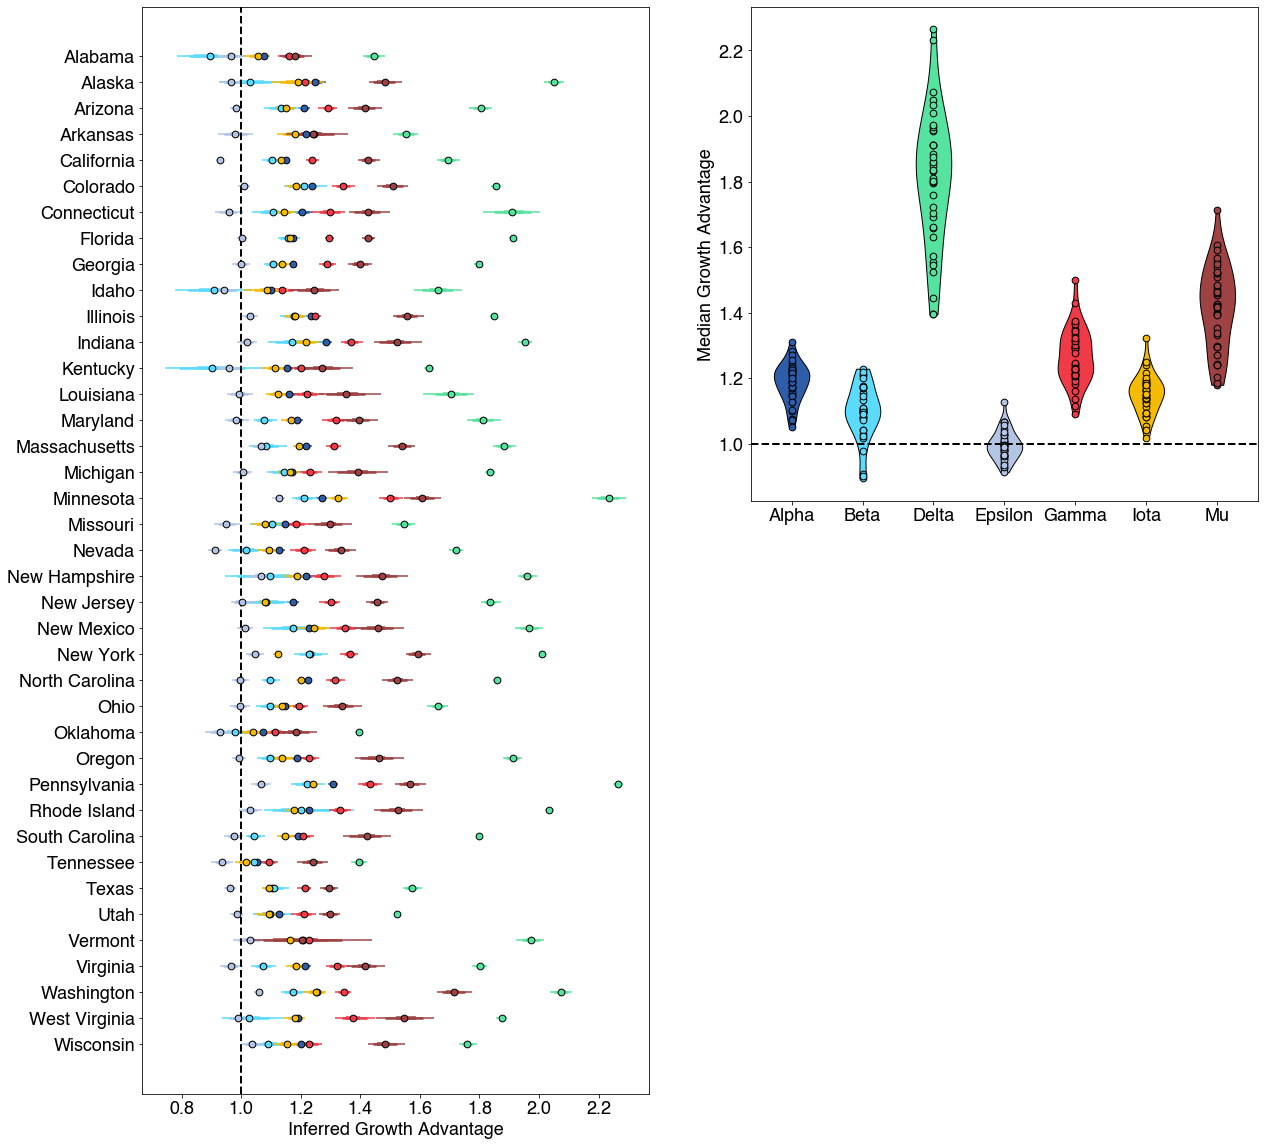

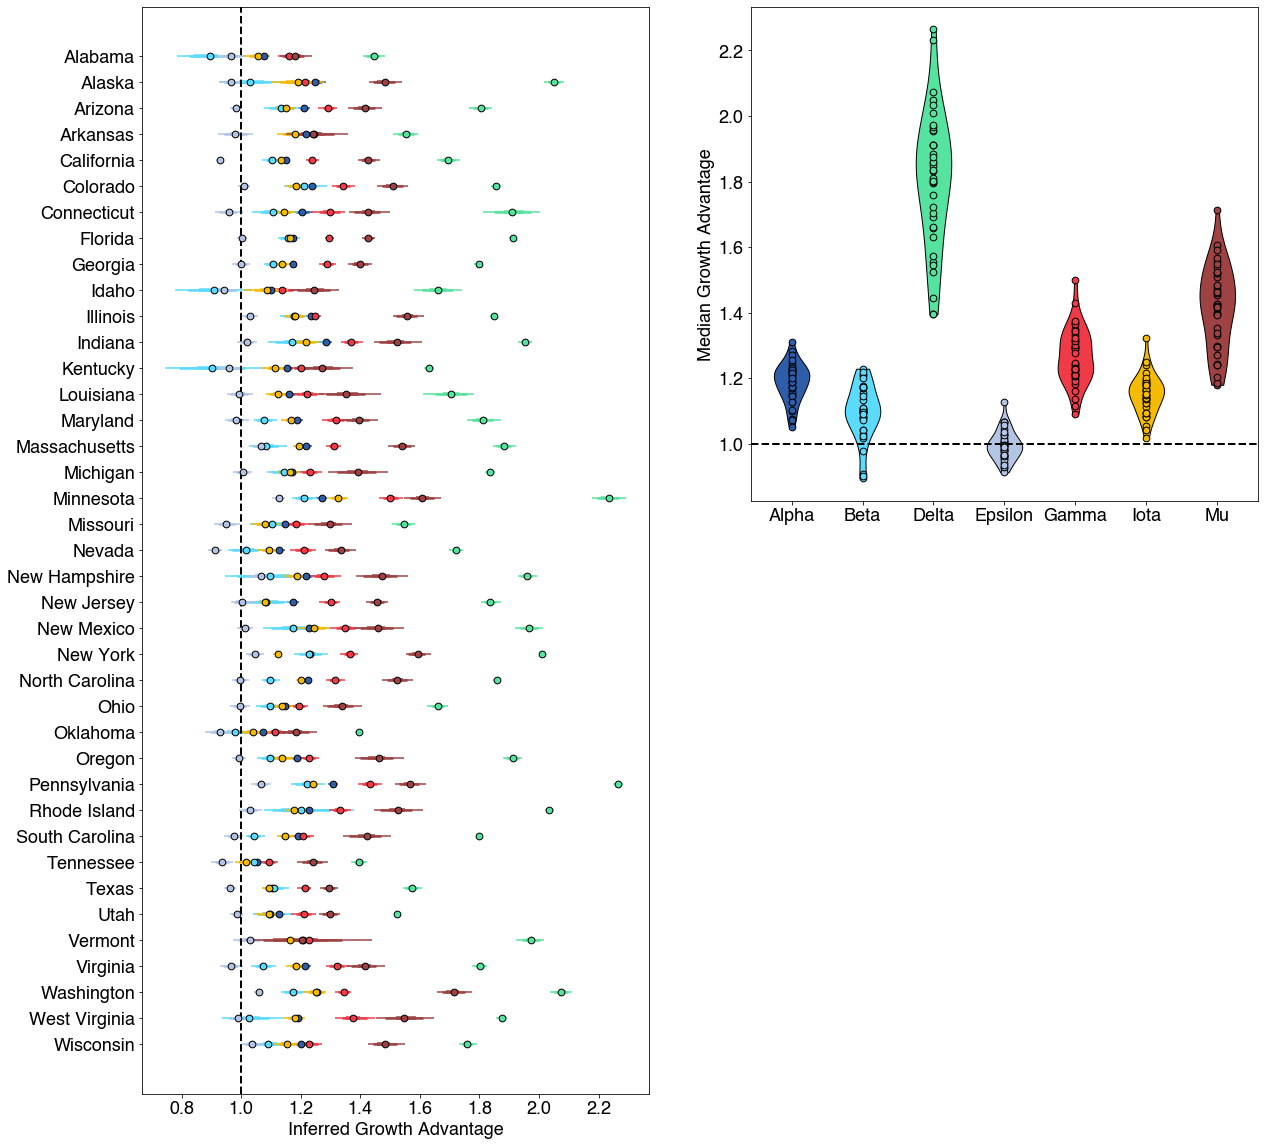

In [43]:
fig_3 = figure_3(ga_df, LD, ps, alphas, lineage_colors)
fig_3

In [44]:
 fig_3.savefig("../manuscript/figs/fig_3_growth_advantages.png", facecolor="w", bbox_inches='tight')

In [45]:
rt_df_free = pd.read_csv(f"{path_free}/Rt/Rt_combined.csv")

In [54]:
def figure_4(rt_df, LD, ps, alphas, colors, thres = 0.001):
    fig = plt.figure(figsize=(20, 12))
    variants = pd.unique(rt_df.variant)
    locations = pd.unique(rt_df.location)
    dates = pd.unique(rt_df.date)
    dates.sort()
    dates_map = {d : i for i, d in enumerate(dates)}
    
    n_rows = 2
    if len(variants) % n_rows == 0:
        n_cols = len(variants) // n_rows
    else:
        n_cols = 1 +  len(variants) // n_rows
    
    ax_list = []
    
    for v, var in enumerate(variants):
        if v == 0:
            ax = fig.add_subplot(n_rows,n_cols, v+1)
        else:
            ax = fig.add_subplot(n_rows,n_cols, v+1, sharey = ax_list[0])
            
        ax.axhline(y=1, lw=2, linestyle='dashed', color="k")    
        this_variant = rt_df[rt_df.variant == var].copy()
        
        for l, loc in enumerate(locations):
            this_loc = this_variant[this_variant.location == loc].copy()
            included = np.array(this_loc.median_freq.values >= thres)
            dates_num = this_loc["date"].map(dates_map)

            m = this_loc["median_R"].values
            ax.plot(dates_num[included], m[included], color = 'k', alpha = 0.1)
                        
            # Plot bands for each level of credibility
            for i, p in enumerate(ps):
                _p = int(p * 100)
                l = this_loc[f"R_lower_{_p}"].values
                r = this_loc[f"R_upper_{_p}"].values
                ax.fill_between(dates_num[included], l[included], r[included], 
                               color = colors[v], alpha=alphas[i])    
        
        # Add dates
        add_dates(ax, LD.dates, sep=2)
        
        if v % n_cols != 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        else: 
            ax.set_ylabel("Effective Reproduction Number")

        # Add to list
        ax_list.append(ax)
        plt.tight_layout()
        
    return fig

In [55]:
rt_df_free

date   location variant  median_R  median_freq  R_upper_95  \
0      2021-01-02    Alabama   Alpha  1.073730     0.018817    1.550390   
1      2021-01-03    Alabama   Alpha  1.096541     0.018817    1.524041   
2      2021-01-04    Alabama   Alpha  1.117060     0.018819    1.496823   
3      2021-01-05    Alabama   Alpha  1.130633     0.018870    1.505939   
4      2021-01-06    Alabama   Alpha  1.142889     0.019105    1.526867   
...           ...        ...     ...       ...          ...         ...   
84442  2021-09-27  Wisconsin   other  1.284883     0.018166    1.487702   
84443  2021-09-28  Wisconsin   other  1.276162     0.018601    1.501597   
84444  2021-09-29  Wisconsin   other  1.263589     0.019162    1.528038   
84445  2021-09-30  Wisconsin   other  1.252354     0.019754    1.565484   
84446  2021-10-01  Wisconsin   other  1.237500     0.020282    1.595212   

       R_lower_95  R_upper_80  R_lower_80  R_upper_50  R_lower_50  
0        0.701531    1.355073    0.811848    1.198824    0.912277  
1        0.767612    1.351724    0.857391    1.210157    0.952431  
2        0.774870    1.359018    0.892498    1.196342    0.952845  
3        0.795053    1.365812    0.915992    1.230100    0.994914  
4        0.817361    1.364859    0.924115    1.218689    0.984211  
...           ...         ...         ...         ...         ...  
84442    1.079312    1.410236    1.145974    1.339500    1.206707  
84443    1.060867    1.427426    1.143375    1.314946    1.176185  
84444    1.039983    1.409146    1.099998    1.316110    1.164876  
84445    1.010273    1.414665    1.077569    1.333336    1.165390  
84446    0.965936    1.414529    1.027243    1.312735    1.120636  

[84447 rows x 11 columns]

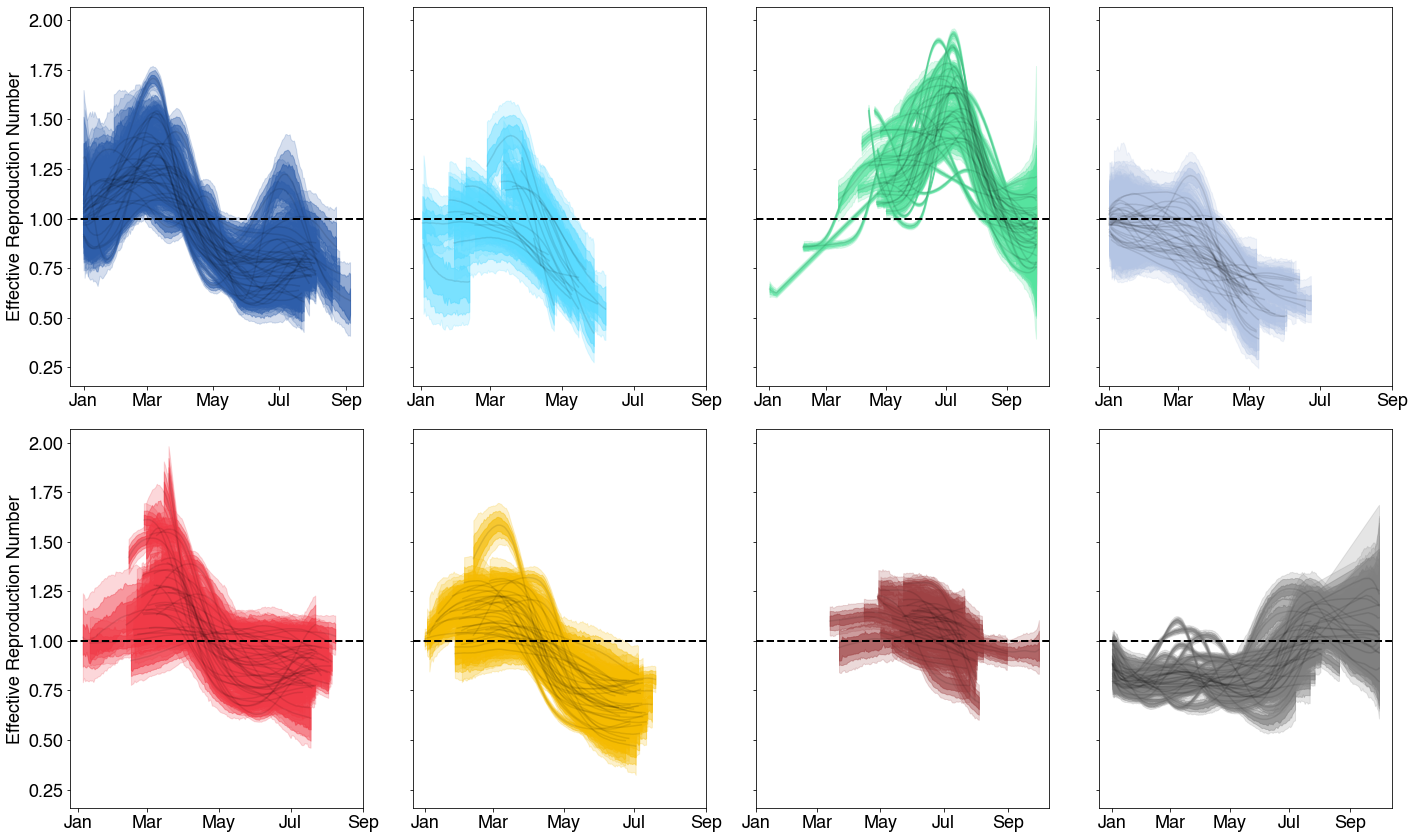

In [59]:
fig_4 = figure_4(rt_df_free, LD, ps, alphas, lineage_colors, thres = 0.01)

In [57]:
fig_4.savefig("../manuscript/figs/fig_4_rt_consensus.png", facecolor="w", bbox_inches='tight')

## Figure 5

In [ ]:
vaccination_effects = pd.read_csv("../sims/all-states-preprint-free/vaccination-effects_11_28_21.tsv")

In [ ]:
def figure_5(vaxx_df, ps, alphas, colors, thres = 0.001):
    return None